# Titanic: Machine Learning from Disaster
## Version #1: Random Forest

__Problem__ 
The sinking of the RMS Titanic is one of the most infamous shipwrecks in history.  On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.

One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

In this challenge, we ask you to complete the analysis of what sorts of people were likely to survive. In particular, we ask you to apply the tools of machine learning to predict which passengers survived the tragedy.

__Algorithm__ In the first iteration we'll be using RandomForest algorithm.
  * [Decision Tress description in sklearn](http://scikit-learn.org/stable/modules/tree.html)
  * [Ensemble methods in sklearn](http://scikit-learn.org/stable/modules/ensemble.html)

In [1]:
%matplotlib inline
import pandas as pd
import math
import numpy as np
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic
from matplotlib import pyplot as plt
from sklearn import ensemble, cross_validation, feature_extraction, grid_search, tree

%config InlineBackend.figure_format = 'svg'
from pylab import rcParams

rcParams['figure.figsize'] = 6, 4
import re
random_state = 153

In [2]:
data_train = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')

## Variable description
* `survival`: (0 = No; 1 = Yes)
* `pclass`: Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)
* `name`
* `sex`
* `age`
* `sibsp`: Number of Siblings/Spouses Aboard
* `parch`: Number of Parents/Children Aboard
* `ticket`: Ticket Number
* `fare`: Passenger Fare
* `cabin`  
* `embarked`: Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)

### Special notes
`Pclass` is a proxy for socio-economic status (SES): 1st ~ Upper; 2nd ~ Middle; 3rd ~ Lower

`Age` is in years; fractional if age less than one. If the `Age` is Estimated, it is in the form xx.5

With respect to the family relation variables (i.e. `sibsp` and `parch`) some relations were ignored.  The following are the definitions used for `sibsp` and `parch`.
 * _Sibling_ - Brother, Sister, Stepbrother, or Stepsister of Passenger Aboard Titanic
 * _Spouse_ - Husband or Wife of Passenger Aboard Titanic (Mistresses and Fiances Ignored)
 * _Parent_ - Mother or Father of Passenger Aboard Titanic
 * _Child_ - Son, Daughter, Stepson, or Stepdaughter of Passenger Aboard Titanic

Other family relatives excluded from this study include cousins, nephews/nieces, aunts/uncles, and in-laws.  Some children travelled only with a nanny, therefore `parch=0` for them.  As well, some travelled with very close friends or neighbors in a village, however, the definitions do not support such relations.

## Data analysis

### Sex

(<matplotlib.figure.Figure at 0x11412bb90>,
 OrderedDict([(('female', '0'), (0.0, 0.0, 0.3506597204772992, 0.25710476754766487)), (('female', '1'), (0.0, 0.26042702668387752, 0.3506597204772992, 0.73957297331612237)), (('male', '0'), (0.3556348448554087, 0.0, 0.6443651551445913, 0.80839719709575819)), (('male', '1'), (0.3556348448554087, 0.81171945623197084, 0.6443651551445913, 0.18828054376802911))]))

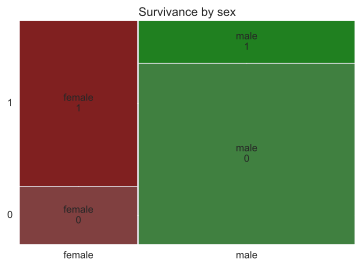

In [3]:
sex_df = data_train.pivot_table(index = 'Sex', columns = 'Survived', values = 'PassengerId', aggfunc = 'count')
mosaic(sex_df.stack(), title = 'Survivance by sex')

It's obvious that females were more likely to survive, that males - so it will be a good feature for our algorithm.

### Fare

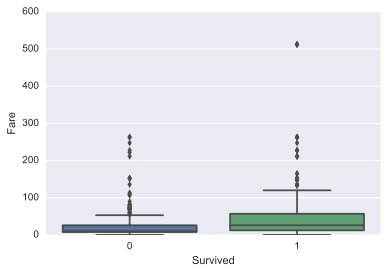

In [4]:
sns.boxplot(x = 'Survived', y = 'Fare', data = data_train)

### Age

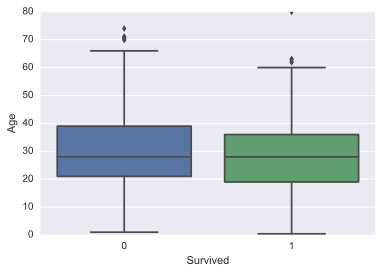

In [5]:
sns.boxplot(x = 'Survived', y = 'Age', data = data_train)

### Class

(<matplotlib.figure.Figure at 0x116e1c310>,
 OrderedDict([(('1', '0'), (0.0, 0.0, 0.24002400240024002, 0.3691399040236249)), (('1', '1'), (0.0, 0.37246216315983754, 0.24002400240024002, 0.6275378368401624)), (('2', '0'), (0.24497449744974498, 0.0, 0.2044648909335378, 0.52542250469449658)), (('2', '1'), (0.24497449744974498, 0.52874476383070912, 0.2044648909335378, 0.47125523616929071)), (('3', '0'), (0.45438988343278774, 0.0, 0.5456101165672124, 0.75512040652001811)), (('3', '1'), (0.45438988343278774, 0.75844266565623075, 0.5456101165672124, 0.24155733434376919))]))

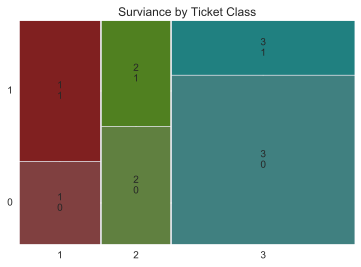

In [6]:
class_df = data_train.pivot_table(index = 'Pclass', columns = 'Survived', values = 'PassengerId', aggfunc = 'count')
mosaic(class_df.stack(), title = 'Surviance by Ticket Class')

Looks like survival rates differ by ticket class: people with higher class were more likely to survive. But also I'd like to check, whether class tickets differ much by fare.

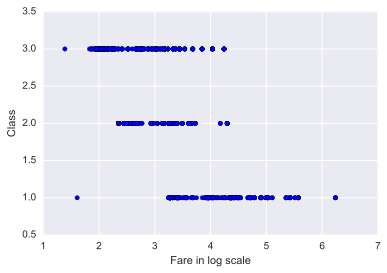

In [7]:
plt.scatter(map(lambda x: math.log(x) if x!=0 else None, data_train.Fare), data_train.Pclass)
plt.xlabel('Fare in log scale')
plt.ylabel('Class')

### Siblings and parents

(<matplotlib.figure.Figure at 0x1173af6d0>,
 OrderedDict([(('0', '0'), (0.0, 0.0, 0.6625042223747727, 0.65243049484175542)), (('0', '1'), (0.0, 0.65575275397796806, 0.6625042223747727, 0.34424724602203183)), (('1', '0'), (0.6673585913068115, 0.0, 0.22773582644132814, 0.46257292279324097)), (('1', '1'), (0.6673585913068115, 0.46589518192945362, 0.22773582644132814, 0.53410481807054633)), (('2', '0'), (0.8999487866801785, 0.0, 0.030510062872522396, 0.53393450403417175)), (('2', '1'), (0.8999487866801785, 0.53725676317038429, 0.030510062872522396, 0.46274323682961555)), (('3', '0'), (0.9353132184847397, 0.0, 0.017434321641441413, 0.74750830564784043)), (('3', '1'), (0.9353132184847397, 0.75083056478405308, 0.017434321641441413, 0.24916943521594684)), (('4', '0'), (0.95760190905822, 0.0, 0.01961361184662147, 0.83056478405315615)), (('4', '1'), (0.95760190905822, 0.83388704318936868, 0.01961361184662147, 0.16611295681063118)), (('5', '0'), (0.9820698898368803, 0.0, 0.005448225512950516, 0.9

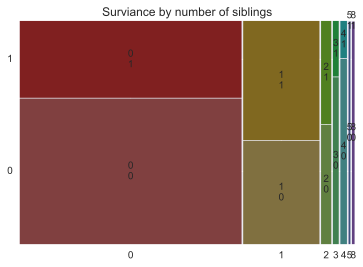

In [8]:

sib_df = data_train.pivot_table(index = 'SibSp', columns = 'Survived', values = 'PassengerId', aggfunc = 'count')
mosaic(sib_df.stack(), title = 'Surviance by number of siblings')

(<matplotlib.figure.Figure at 0x11739d050>,
 OrderedDict([(('0', '0'), (0.0, 0.0, 0.7387793795560788, 0.65416164407726451)), (('0', '1'), (0.0, 0.65748390321347705, 0.7387793795560788, 0.34251609678652278)), (('1', '0'), (0.7436337484881176, 0.0, 0.12857812210563027, 0.44766034123542991)), (('1', '1'), (0.7436337484881176, 0.45098260037164256, 0.12857812210563027, 0.54901739962835738)), (('2', '0'), (0.8770662395257867, 0.0, 0.08717160820720686, 0.49833887043189368)), (('2', '1'), (0.8770662395257867, 0.50166112956810627, 0.08717160820720686, 0.49833887043189368)), (('3', '0'), (0.9690922166650323, 0.0, 0.005448225512950516, 0.39867109634551495)), (('3', '1'), (0.9690922166650323, 0.4019933554817276, 0.005448225512950516, 0.59800664451827235)), (('4', '0'), (0.9793948111100217, 0.0, 0.004358580410360326, 0.99667774086378735)), (('4', '1'), (0.9793948111100217, 1.0, 0.004358580410360326, 0.0)), (('5', '0'), (0.9886077604524208, 0.0, 0.005448225512950408, 0.79734219269102991)), (('5', '1

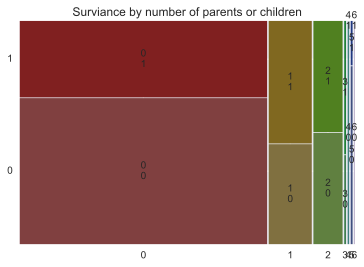

In [9]:
par_df = data_train.pivot_table(index = 'Parch', columns = 'Survived', values = 'PassengerId', aggfunc = 'count')
mosaic(par_df.stack(), title = 'Surviance by number of parents or children')

There is a trend in data: firstly with the increase of family members probability of survival is also rising, but then it drops. So let's add one more feature `family_size`: depending on sum of number of siblings and number of parents and children:
 * _0_: alone
 * _1-3_: small family
 * _4+_: large family

(<matplotlib.figure.Figure at 0x118463e90>,
 OrderedDict([(('alone', '0'), (0.0, 0.0, 0.5967263393005967, 0.6941479982924702)), (('alone', '1'), (0.0, 0.69747025742868274, 0.5967263393005967, 0.30252974257131715)), (('large', '0'), (0.6016768343501017, 0.0, 0.06889577846673557, 0.83592326653091842)), (('large', '1'), (0.6016768343501017, 0.83924552566713095, 0.06889577846673557, 0.16075447433286888)), (('small', '0'), (0.6755231078663423, 0.0, 0.32447689213365777, 0.41983343193919809)), (('small', '1'), (0.6755231078663423, 0.42315569107541073, 0.32447689213365777, 0.57684430892458916))]))

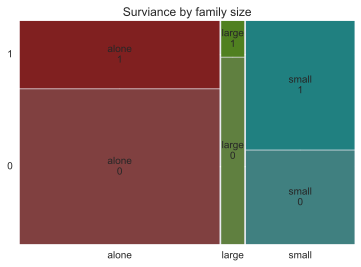

In [10]:
def determine_family_size(sibsp, parch):
    n = sibsp + parch
    if n == 0:
        return 'alone'
    elif n in [1, 2, 3]:
        return 'small'
    else:
        return 'large'
data_train['family_size'] = map(determine_family_size, data_train.SibSp, data_train.Parch)
family_df = data_train.pivot_table(index = 'family_size', columns = 'Survived', values = 'PassengerId', aggfunc = 'count')
mosaic(family_df.stack(), title = 'Surviance by family size')

### Title

Also I believe title from name could be a good feature. Let's exctract it using regular expressions.

In [11]:
title_re = re.compile('([ \w\'-]+), (\w+)')

In [12]:
data_train['title'] = map(lambda x: title_re.match(x).groups()[1] if title_re.match(x) is not None else '', data_train.Name)

In [13]:
title_freq = pd.DataFrame(data_train.title.value_counts()).sort('title', ascending = False)
title_freq

/Users/miptgirl/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,title
Mr,517
Miss,182
Mrs,125
Master,40
Dr,7
Rev,6
Col,2
Mlle,2
Major,2
Jonkheer,1


We'll combine rare titles in one group 'other', not to overfit our model. 

In [14]:
def determine_title(name):
    title = title_re.match(name).groups()[1]
    if title in ['Mr', 'Miss', 'Master', 'Mrs']:
        return title
    elif title == 'Mme':
        return 'Mrs'
    elif title == 'Ms':
        return 'Miss'
    elif title == 'Mlle':
        return 'Miss'
    else:
        return 'other'
    
data_train['title'] = map(determine_title, data_train.Name)

(<matplotlib.figure.Figure at 0x118806190>,
 OrderedDict([(('Master', '0'), (0.0, 0.0, 0.04401311590854074, 0.42358803986710958)), (('Master', '1'), (0.0, 0.42691029900332222, 0.04401311590854074, 0.57308970099667766)), (('Miss', '0'), (0.04891507669285446, 0.0, 0.20356066107700097, 0.29630959863518003)), (('Miss', '1'), (0.04891507669285446, 0.29963185777139267, 0.20356066107700097, 0.70036814222860722)), (('Mr', '0'), (0.25737769855416914, 0.0, 0.5688695231178891, 0.84052513542864837)), (('Mr', '1'), (0.25737769855416914, 0.84384739456486102, 0.5688695231178891, 0.15615260543513887)), (('Mrs', '0'), (0.8311491824563719, 0.0, 0.13864131511190336, 0.20566366081316245)), (('Mrs', '1'), (0.8311491824563719, 0.20898591994937507, 0.13864131511190336, 0.7910140800506249)), (('other', '0'), (0.9746924583525891, 0.0, 0.025307541647410923, 0.65000722230246999)), (('other', '1'), (0.9746924583525891, 0.65332948143868252, 0.025307541647410923, 0.34667051856131731))]))

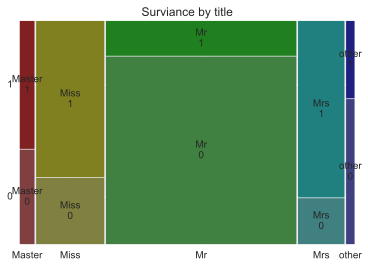

In [15]:
title_df = data_train.pivot_table(index = 'title', columns = 'Survived', values = 'PassengerId', aggfunc = 'count')
mosaic(title_df.stack(), title = 'Surviance by title')

## Data preprocessing

In [16]:
X_train = data_train.drop('Survived', axis = 1)
X_test = data_test

y_train = data_train.Survived

In [17]:
X_train['family_size'] = map(determine_family_size, X_train.SibSp, X_train.Parch)
X_test['family_size'] = map(determine_family_size, X_test.SibSp, X_test.Parch)

In [18]:
X_train['title'] = map(determine_title, X_train.Name)
X_test['title'] = map(determine_title, X_test.Name)

In [19]:
numeric_cols = ['Pclass', 'Age', 'Fare', 'SibSp', 'Parch']
escape_cols = ['PassengerId', 'Name', 'Ticket', 'Cabin'] # not used data
target_cols = ['Survived']
categorical_cols = list(set(data_train.columns) - set(numeric_cols) - set(escape_cols) - set(target_cols))

### Dealing with NAs

In [20]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
family_size    891 non-null object
title          891 non-null object
dtypes: float64(2), int64(5), object(7)
memory usage: 97.5+ KB


In [21]:
X_num_train = X_train[numeric_cols]
X_cat_train = X_train[categorical_cols]

X_num_test = X_test[numeric_cols]
X_cat_test = X_test[categorical_cols]

In [22]:
# for numeric values let's fill missing values with medians
X_num_train = X_num_train.fillna(X_num_train.median())
X_num_test = X_num_test.fillna(X_num_train.median())

In [23]:
# for Embarkment let's fill missing values with most common value
embarkment_mode = X_cat_train.Embarked.mode().values[0]
X_cat_train.Embarked.fillna(embarkment_mode, inplace = True)
X_cat_test.Embarked.fillna(embarkment_mode, inplace = True)

/Users/miptgirl/anaconda/lib/python2.7/site-packages/pandas/core/generic.py:3178: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [24]:
# Also we found out that there are a lot of adult passengers that has fare equals to 0, that looks like a mistake, 
# so let's change it also to median
fare_median = X_num_train.Fare.median()
X_num_train['Fare'] = map(lambda x: x if x != 0 else fare_median, X_num_train.Fare)
X_num_test['Fare'] = map(lambda x: x if x != 0 else fare_median, X_num_test.Fare)

### Dealing with categorical variables

In [25]:
X_cat_train['Sex'] = map(lambda x: int(x == 'male'), X_cat_train.Sex)
X_cat_test['Sex'] = map(lambda x: int(x == 'male'), X_cat_test.Sex)

/Users/miptgirl/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/miptgirl/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [26]:
encoder = feature_extraction.DictVectorizer()
X_cat_train_enc = encoder.fit_transform(X_cat_train.T.to_dict().values())
X_cat_train_enc = pd.DataFrame(X_cat_train_enc.toarray())
X_cat_train_enc.columns = encoder.get_feature_names()
print encoder.get_feature_names()

['Embarked=C', 'Embarked=Q', 'Embarked=S', 'Sex', 'family_size=alone', 'family_size=large', 'family_size=small', 'title=Master', 'title=Miss', 'title=Mr', 'title=Mrs', 'title=other']


In [27]:
X_cat_test_enc = encoder.transform(X_cat_test.T.to_dict().values())
X_cat_test_enc = pd.DataFrame(X_cat_test_enc.toarray())
X_cat_test_enc.columns = encoder.get_feature_names()

### Summing up

In [28]:
X_train = pd.concat([X_num_train, X_cat_train_enc], axis = 1)
X_test = pd.concat([X_num_test, X_cat_test_enc], axis = 1)

## Tuning RandomForest params 

In [29]:
clf = ensemble.RandomForestClassifier(n_estimators = 100)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [30]:
pd.DataFrame({'param': X_train.columns, 'importance':clf.feature_importances_}).sort('importance', ascending = False)

/Users/miptgirl/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,importance,param
2,0.234323,Fare
1,0.219229,Age
14,0.130053,title=Mr
8,0.106470,Sex
0,0.074065,Pclass
15,0.037116,title=Mrs
13,0.036720,title=Miss
3,0.031431,SibSp
4,0.024861,Parch
10,0.023375,family_size=large


In [31]:
clf = ensemble.RandomForestClassifier()
clf.get_params().keys()

['warm_start',
 'oob_score',
 'n_jobs',
 'verbose',
 'max_leaf_nodes',
 'bootstrap',
 'min_samples_leaf',
 'n_estimators',
 'min_samples_split',
 'min_weight_fraction_leaf',
 'criterion',
 'random_state',
 'max_features',
 'max_depth',
 'class_weight']

In [32]:
parameters_grid = {
    'n_estimators': [25, 50, 75, 100, 250, 500],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': np.arange(1, 11, 1)
}

In [33]:
clf = ensemble.RandomForestClassifier()
grid_cv = grid_search.GridSearchCV(clf, parameters_grid, cv = 5, verbose = 100)

In [34]:
%%time
grid_cv.fit(X_train, y_train)

Fitting 5 folds for each of 180 candidates, totalling 900 fits
[CV] max_features=sqrt, n_estimators=25, max_depth=1 .................
[CV]  max_features=sqrt, n_estimators=25, max_depth=1, score=0.804469 -   0.1s
[Parallel(n_jobs=1)]: Done   1 tasks       | elapsed:    0.1s
[CV] max_features=sqrt, n_estimators=25, max_depth=1 .................
[CV]  max_features=sqrt, n_estimators=25, max_depth=1, score=0.804469 -   0.1s
[Parallel(n_jobs=1)]: Done   2 tasks       | elapsed:    0.2s
[CV] max_features=sqrt, n_estimators=25, max_depth=1 .................
[CV]  max_features=sqrt, n_estimators=25, max_depth=1, score=0.803371 -   0.1s
[Parallel(n_jobs=1)]: Done   3 tasks       | elapsed:    0.3s
[CV] max_features=sqrt, n_estimators=25, max_depth=1 .................
[CV]  max_features=sqrt, n_estimators=25, max_depth=1, score=0.730337 -   0.1s
[Parallel(n_jobs=1)]: Done   4 tasks       | elapsed:    0.4s
[CV] max_features=sqrt, n_estimators=25, max_depth=1 .................
[CV]  max_features

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [25, 50, 75, 100, 250, 500], 'max_features': ['sqrt', 'log2', None], 'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=100)

In [45]:
best_params = grid_cv.best_params_
best_max_depth = best_params['max_depth']
best_max_features = best_params['max_features']
best_n_estimators = best_params['n_estimators']
best_params

{'max_depth': 7, 'max_features': None, 'n_estimators': 100}

In [46]:
grid_cv.best_score_

0.84287317620650959

In [47]:
scores = []
for elem in grid_cv.grid_scores_:
    scores.append(elem[1])

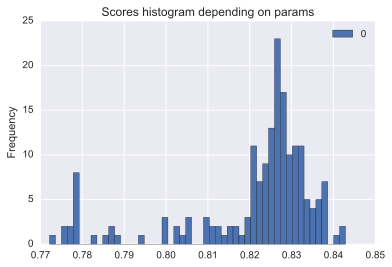

In [48]:
pd.DataFrame(scores).plot.hist(bins = 50, title = 'Scores histogram depending on params')

In [54]:
clf = ensemble.RandomForestClassifier(max_depth = best_max_depth, 
                                      n_estimators = best_n_estimators, 
                                      max_features = best_max_features,
                                      oob_score = True
                                     )
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features=None, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [55]:
predictions = clf.predict(X_test)

In [56]:
pd.DataFrame({'PassengerId': data_test.PassengerId.tolist(), 'Survived': predictions}).to_csv('predictions_random_forest.csv', index = False)

In [58]:
clf.oob_score_

0.84511784511784516